In [1]:
import torch
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [2]:
cfg = {
    'A':[64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B':[64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D':[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E':[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
    }

In [3]:
class VGGNet(nn.Module):
    def __init__(self, features, in_channels=3, num_classes=1000, init_weights=True):
        super(VGGNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        self.fc_layers = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )
        if init_weights:
            self._init_weights()

    def forward(self, x):
        # conv & pooling layers
        x = self.features(x)
        x = self.avgpool(x)
        # fc layers
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def _init_weights(self):
        # class 내부에 정의 된 layer들을 가져옴
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # 뒤에 _를 붙이므로써 inplace=True의 효과를 냄
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.001)
                nn.init.constant_(m.bias, 0)

In [4]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3

    for x in cfg:
        if type(x) == int:
            out_channels = x
            conv2d = nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
            )
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(x), nn.ReLU()]
            else:
                layers += [conv2d, nn.ReLU()]
            in_channels = x
        else:
            layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

    return nn.Sequential(*layers)

In [5]:
num_classes = 10
batch_size = 128
log = 100
epochs = 10
step_size = 5

momentum = 0.9
gamma = 0.9
learning_rate = 10**(-2)
weight_decay = 5*10**(-4)

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(2021)

if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(2021)

In [7]:
vgg16 = VGGNet(make_layers(cfg['D'], batch_norm=True), num_classes=num_classes)
vgg16 = vgg16.to(DEVICE)

In [8]:
# CIFAR10 데이터셋
transform = transforms.Compose( # resize 하지 않음
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


trainset = torchvision.datasets.CIFAR10(
    root='data', train=True, 
    download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, drop_last = True)

testset = torchvision.datasets.CIFAR10(
    root='data', train=False,
    download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [9]:
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(params=vgg16.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

[1,   100] loss: 0.463
[1,   200] loss: 0.494
[1,   300] loss: 0.475
[2,   100] loss: 0.416
[2,   200] loss: 0.418
[2,   300] loss: 0.454
[3,   100] loss: 0.371
[3,   200] loss: 0.408
[3,   300] loss: 0.414
[4,   100] loss: 0.336
[4,   200] loss: 0.366
[4,   300] loss: 0.372
[5,   100] loss: 0.293
[5,   200] loss: 0.315
[5,   300] loss: 0.314
[6,   100] loss: 0.250
[6,   200] loss: 0.273
[6,   300] loss: 0.278
[7,   100] loss: 0.225
[7,   200] loss: 0.250
[7,   300] loss: 0.266
[8,   100] loss: 0.199
[8,   200] loss: 0.211
[8,   300] loss: 0.219
[9,   100] loss: 0.184
[9,   200] loss: 0.180
[9,   300] loss: 0.206
[10,   100] loss: 0.162
[10,   200] loss: 0.162
[10,   300] loss: 0.170


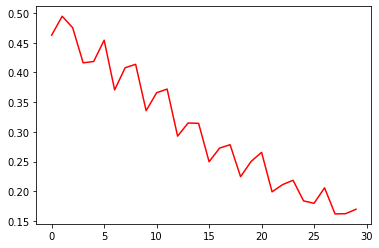

In [13]:
loss_values = []

for epoch in range(epochs):
    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloader):
        X, y = data
        X, y = X.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        pred = vgg16(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if (i+1) % log == 0:
            loss_values.append(running_loss / log)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / log))
            running_loss = 0.0

plt.plot(np.array(loss_values),'r')

In [18]:
correct = 0.0
total = 0.0

with torch.no_grad():
    for data in testloader:
        X, y = data
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        pred = vgg16(X)

        _, predicted = torch.max(pred.data, 1)

        total += y.size(0)
        correct += (predicted == y).sum().item()

print('Acc : %d %%' % ( 100 * correct / total))

Acc : 80 %
